# Part 2: Supervised Models

#### In this notebook:
A. [Imports](#imports): Libraries & Dataset  

B. [Models](#models):
  1. [Baseline Model](#baseline)
  2. [Logistic Regression](#logreg)
  3. [Decision Tree](#tree)
  4. [Random Forests](#rf)
  5. [Extra Tree](#et)  

C. [Scores Summary](#all_scores)

<a id='#imports'> </a>
## Imports

In [2]:
import os
import os.path as op
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.datasets import make_classification
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

from dtreeviz.trees import dtreeviz
import graphviz

In [13]:
# Loading the dataset
with open('data/all_samples.pkl', 'rb') as f:
    all_samples = pickle.load(f)

all_samples.shape

(734, 233656)

 <a id='#models'></a>

## Models

### 1. Baseline Model <a id='#baseline'></a>

In [6]:
# Find the ratio of classes in the dataset
all_samples['is_cancer'].value_counts(normalize=True).round(2)

1    0.87
0    0.13
Name: is_cancer, dtype: float64

About 87% of the samples are malignant while 13% are benign.

### 2. Logistic Regression <a id='#logreg'></a>

#### Set up X & y

In [7]:
X = all_samples.drop(columns=['is_cancer'])
y = all_samples['is_cancer']

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Make a logistic regression model only with the 40,000 sites that has most variance:

In [196]:
# Create a pipeline: instantiate th model and scale the date
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# apply scaling on training data
pipe.fit(X_train, y_train) 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

C:\Users\Marva\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [197]:
# Score the test set
pipe.score(X_test, y_test)

0.8369565217391305

### 3. A Decision Tree Model <a id='#tree'></a>

In [9]:
# instantiate the dacision tree model
tree = DecisionTreeRegressor(random_state=1, max_depth=3)

# fitting
tree.fit(X_train, y_train)

# evaluate
tree.score(X_train, y_train), tree.score(X_test, y_test)

(1.0, 0.7125)

The model overfits on the train set, predicting the test with an accuracy of 0.7125 (worse than the baseline model).
Meaning, the decision tree model correctly predicts malignancy or benignity in 71.25% of cases.

#### Decision Tree Diagram

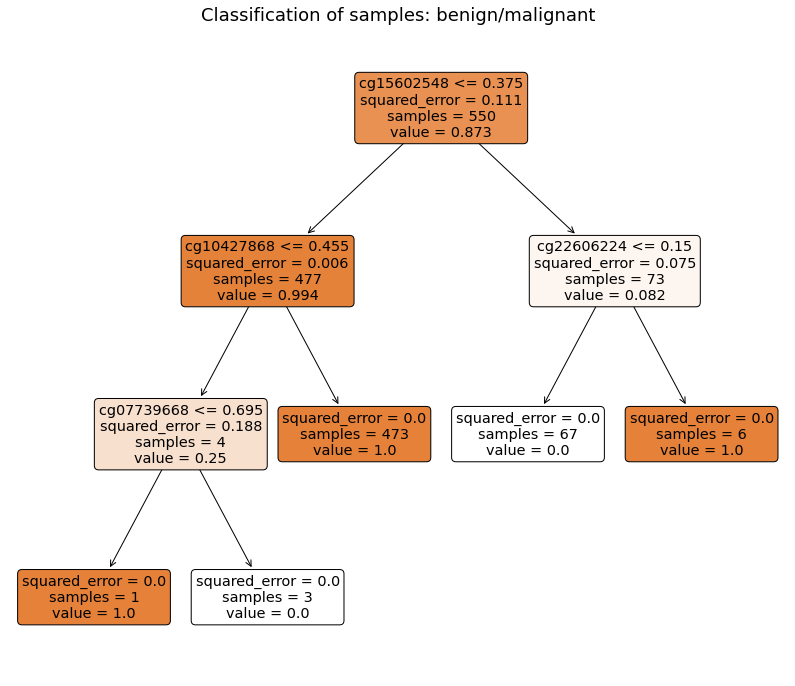

In [188]:
plt.figure(figsize=(14,12))
plot_tree(tree, 
          feature_names=X_train.columns, 
          rounded=True,
          class_names=['Benign', 'Malignant'],
          filled=True)
plt.title('Classification of Samples: Benign/Malignant', fontsize=18);

### 4. Random Forests Models <a id='#rf'></a>

#### 4.1 RF model without tuning the hyperparameters

In [11]:
# Instantiate a random forest model
# Using class_weight='balanced' to handle the imbalance data
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')

cross_val_score(rf, X_train, y_train, cv=5).mean()

0.9872727272727273

#### 4.2 Tuning the RF hyperparameters with grid search

In [198]:
rf_params = {                              
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)

# fitting
gs.fit(X_train, y_train)

# get best score and best params
print(gs.best_score_)
gs.best_params_

0.990909090909091


{'max_depth': None, 'n_estimators': 200}

In [200]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9981818181818182, 0.9836956521739131)

In [12]:
# Building an random forest model with the best params found in the grid search:

rf2 = RandomForestClassifier(n_estimators=100,
                            max_depth=4,
                            max_features='auto',
                            min_samples_leaf=4,
                            bootstrap=True,
                            n_jobs=-1,
                            random_state=0,
                            class_weight='balanced' 
)

# fitting
rf2.fit(X_train, y_train)

# score the rf model
rf2.score(X_train, y_train)

0.9963636363636363

In [ ]:
# interpret

#### 4.3 Tuning the RF hyperparameters with halving grid search

In [203]:
param_grid_2 = {'max_depth': [3, 5, 10],
               'min_samples_split': [2, 5, 10]}
base_estimator_2 = RandomForestClassifier(random_state=0)
X_train, y_train = make_classification(n_samples=1000, random_state=0)
sh = HalvingGridSearchCV(base_estimator_2, param_grid_2, cv=5,
                         factor=2, resource='n_estimators',
                         max_resources=30).fit(X_train, y_train)

# retrieve the best estimator
sh.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=24, random_state=0)

In [204]:
# make a random forest with the best estimator found in HalvingGridSearchCV:
rf_sh = RandomForestClassifier(n_estimators=100,
                            max_depth=5,
                            max_features='auto',
                            min_samples_leaf=4,
                            bootstrap=True,
                            n_jobs=-1,
                            random_state=0,
                            class_weight='balanced'                           
)

# fitting
rf_sh.fit(X_train, y_train)

# evaluate the rf_sh model:
cross_val_score(rf_sh, X_train, y_train, cv=5).mean()

0.9550000000000001

In [205]:
#interprate

### 5. Extra Tree Models <a id='#et'></a>

#### 5.1 ET model without tuning the hyperparameters

In [206]:
et = ExtraTreesClassifier(n_estimators=100, class_weight='balanced')

In [207]:
cross_val_score(et, X_train, y_train, cv=5).mean()

0.9570000000000001

#### 5.2 Tuning the ET hyperparameters grid search

In [208]:
et_params = {                  
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs_et = GridSearchCV(et, param_grid=et_params, cv=5)

# fitting
gs_et.fit(X_train, y_train)

# get best score and best params
print(gs_et.best_score_)
gs_et.best_params_

0.96


{'max_depth': None, 'n_estimators': 200}

In [212]:
# Building an extra-tree model with the best params found in the grid search:

et2 = ExtraTreesClassifier(n_estimators=200,
                            max_depth=None,
                            max_features='auto',
                            min_samples_leaf=6,
                            bootstrap=True,
                            n_jobs=-1,
                            random_state=0,
                            class_weight='balanced'
)

#fitting
et2.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
                     min_samples_leaf=6, n_estimators=200, n_jobs=-1,
                     random_state=0)

In [214]:
cross_val_score(et2, X_train, y_train, cv=5).mean()

0.95

#### 5.3 Tuning the ET hyperparameters halving grid search

In [215]:
# Use HalvingGridSearchCV to find the best hyperparams
param_grid_3 = {'max_depth': [3, 5, 10],
               'min_samples_split': [2, 5, 10]}

base_estimator_3 = ExtraTreesClassifier(random_state=0)

X_train, y_train = make_classification(n_samples=1000, random_state=0)

sh2 = HalvingGridSearchCV(base_estimator_3, param_grid_3, cv=5,
                         factor=2, resource='n_estimators',
                         max_resources=30).fit(X_train, y_train)

# retrieve the best estimator
sh2.best_estimator_

ExtraTreesClassifier(max_depth=10, min_samples_split=5, n_estimators=24,
                     random_state=0)

In [211]:
# make an extra tree model with the best estimator found in HalvingGridSearchCV:
et_sh2 = ExtraTreesClassifier(n_estimators=100,
                            max_depth=10,
                            max_features='auto',
                            min_samples_leaf=5,
                            bootstrap=True,
                            n_jobs=-1,
                            random_state=0,
                            class_weight='balanced'                           
)
et_sh2.fit(X_train, y_train)

# evaluating the rf_sh model:
cross_val_score(et_sh2, X_train, y_train, cv=5).mean()

0.9469999999999998

### Saving the best scored models as pickle files

In [218]:
with open('models/et_class_model.pkl', 'wb') as f:
    pickle.dump(et2, f)

In [219]:
with open('models/rf2_class_model.pkl', 'wb') as f:
    pickle.dump(rf2, f)     # gs???

## Accuracy Scores Summary <a id='#all_scores'></a>

|     Model type     | Hyper Parameters Search |  Accuracy Score  |   
|--------------------|-------------------------|------------------|  
| Baseline Model | None | 0.870
|Decision Tree       |None                     |0.712           |
|Random Forest|None|0.987|  
|Random Forest|GridSearchCV|0.987|
|Random Forest|HalvingGridSearchCV|0.955|  
|Extra Tree|None|0.957|  
|Extra Tree|GridSearchCV|0.989|  
|Extra Tree|HalvingGridSearchCV|0.945|



The Random Forest and Extra Tree models performed similarly with an accuracy score of nearly 0.99 after tuning the hyper parameters with grid search.  
All models except the Decision Tree beat the baseline model.